In [1]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
# Confusion matrix generation
def get_clf_eval(y_test,pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred, average = 'macro')
    recall = recall_score(y_test,pred, average = 'macro')
    f1 = f1_score(y_test, pred, average = 'macro')
    roc_auc = roc_auc_score(y_test, pred_proba, average = 'macro', multi_class='ovr')
    print('Confusion matrix')
    print(confusion)
    print('Accuracy:{0:.4f}, Precision:{1:.4f}, Recall:{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 1. Load train and test data

In [4]:
train_data = pd.read_csv("data/train_data_PCA.csv", header=None)
test_data = pd.read_csv("data/test_data_PCA.csv", header=None)

X_train = train_data.iloc[:,:2]
y_train = train_data.iloc[:,2]

X_test = test_data.iloc[:,:2]
y_test = test_data.iloc[:,2]

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

### 2. Train the XGBoost model

In [5]:
xgb_clf = XGBClassifier(objective = 'multiclass', num_class='4', early_stopping = 100)

params = {'max_depth': range(4, 12, 2),
          'n_estimators': range(60, 200, 20),
          'learning_rate': [0.1, 0.01, 0.05]}

In [6]:
grid_search = GridSearchCV(estimator = xgb_clf, param_grid = params, scoring = 'accuracy', n_jobs=-1, cv = 5, verbose=True)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[15:11:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, early_stopping=100,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n

In [7]:
print("GridSearchCV optimal paramters:", grid_search.best_params_)
print("GridSearchCV the highest accuracy:{0:.4f}".format(grid_search.best_score_))

GridSearchCV optimal paramters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 80}
GridSearchCV the highest accuracy:0.9158


In [8]:
scores_df = pd.DataFrame(grid_search.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 
           'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.915278,3,0.915278,0.917361,0.902778,0.918750,0.922222
1,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.915278,6,0.915972,0.914583,0.904167,0.920833,0.920833
2,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.914028,48,0.914583,0.913889,0.900694,0.919444,0.921528
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.914306,42,0.915972,0.915278,0.899306,0.919444,0.921528
4,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.914028,48,0.915278,0.915278,0.900000,0.918056,0.921528
...,...,...,...,...,...,...,...,...
79,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.913194,61,0.914583,0.911806,0.898611,0.918750,0.922222
80,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.913611,57,0.915278,0.911111,0.900000,0.919444,0.922222
81,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.913194,61,0.914583,0.911806,0.897917,0.919444,0.922222
82,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.912778,65,0.913889,0.912500,0.897917,0.918750,0.920833


### 3. Test the XGBoost model

In [9]:
estimator = grid_search.best_estimator_

preds = estimator.predict(X_test_scaled)
pred_probs = estimator.predict_proba(X_test)

In [10]:
get_clf_eval(y_test, preds, pred_probs)

Confusion matrix
[[120   0  18  14]
 [  0 120  15   0]
 [  2   5 112   1]
 [  0   0   0 126]]
Accuracy:0.8968, Precision:0.9024, Recall:0.9029, F1:0.8970, AUC:0.6630


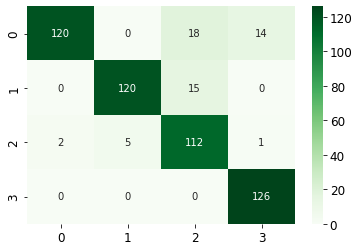

In [11]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test,preds)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
labels = np.asarray(group_counts).reshape(4,4)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

In [12]:
print(metrics.classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9836    0.7895    0.8759       152
           1     0.9600    0.8889    0.9231       135
           2     0.7724    0.9333    0.8453       120
           3     0.8936    1.0000    0.9438       126

    accuracy                         0.8968       533
   macro avg     0.9024    0.9029    0.8970       533
weighted avg     0.9088    0.8968    0.8970       533



Text(0, 0.5, 'PC2')

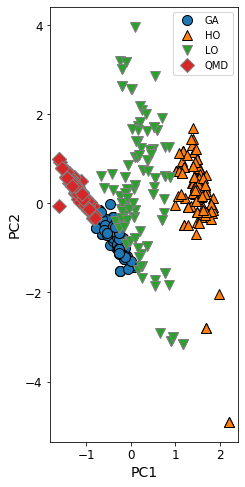

In [13]:
import mglearn

plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_test_scaled[:,0], X_test_scaled[:,1], preds)
plt.legend(["GA", "HO", "LO", "QMD"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")